In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Espírito Santo - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_ES.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - Consumo de Cimento (t),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,2003-1,8.177444,0.760059,0.698032,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,48.426,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,4.069229e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445
1,2003-2,8.171622,0.760222,0.698295,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,54.969,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,4.094341e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512
2,2003-3,8.165799,0.760385,0.698558,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,53.847,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,4.119454e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941
3,2003-4,8.159977,0.760548,0.698821,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,50.375,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,4.144566e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321
4,2003-5,8.154154,0.760710,0.699084,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,52.576,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,4.169679e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36954.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36937.748495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36867.947370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36784.826883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


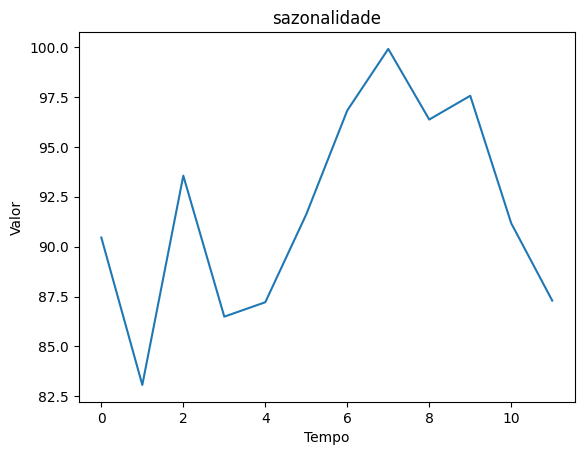

,sazonalidade
sazonalidade,
0,90.455481
1,83.073464
2,93.552817
3,86.493489
4,87.214724
5,91.618204
6,96.820979
7,99.901936
8,96.365147


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade,Espírito Santo - Consumo de Cimento (t)
0,2003-1,8.177444,0.760059,0.698032,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,4.069229e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445,90.455481,48.426
1,2003-2,8.171622,0.760222,0.698295,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,4.094341e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512,83.073464,54.969
2,2003-3,8.165799,0.760385,0.698558,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,4.119454e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941,93.552817,53.847
3,2003-4,8.159977,0.760548,0.698821,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,4.144566e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321,86.493489,50.375
4,2003-5,8.154154,0.760710,0.699084,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,4.169679e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453,87.214724,52.576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36954.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.214724,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36937.748495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.618204,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36867.947370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.820979,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36784.826883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.901936,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      56.490
1      53.578
2      60.481
3      64.833
4      64.063
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Espírito Santo - Consumo de Cimento (t), Length: 249, dtype: float64

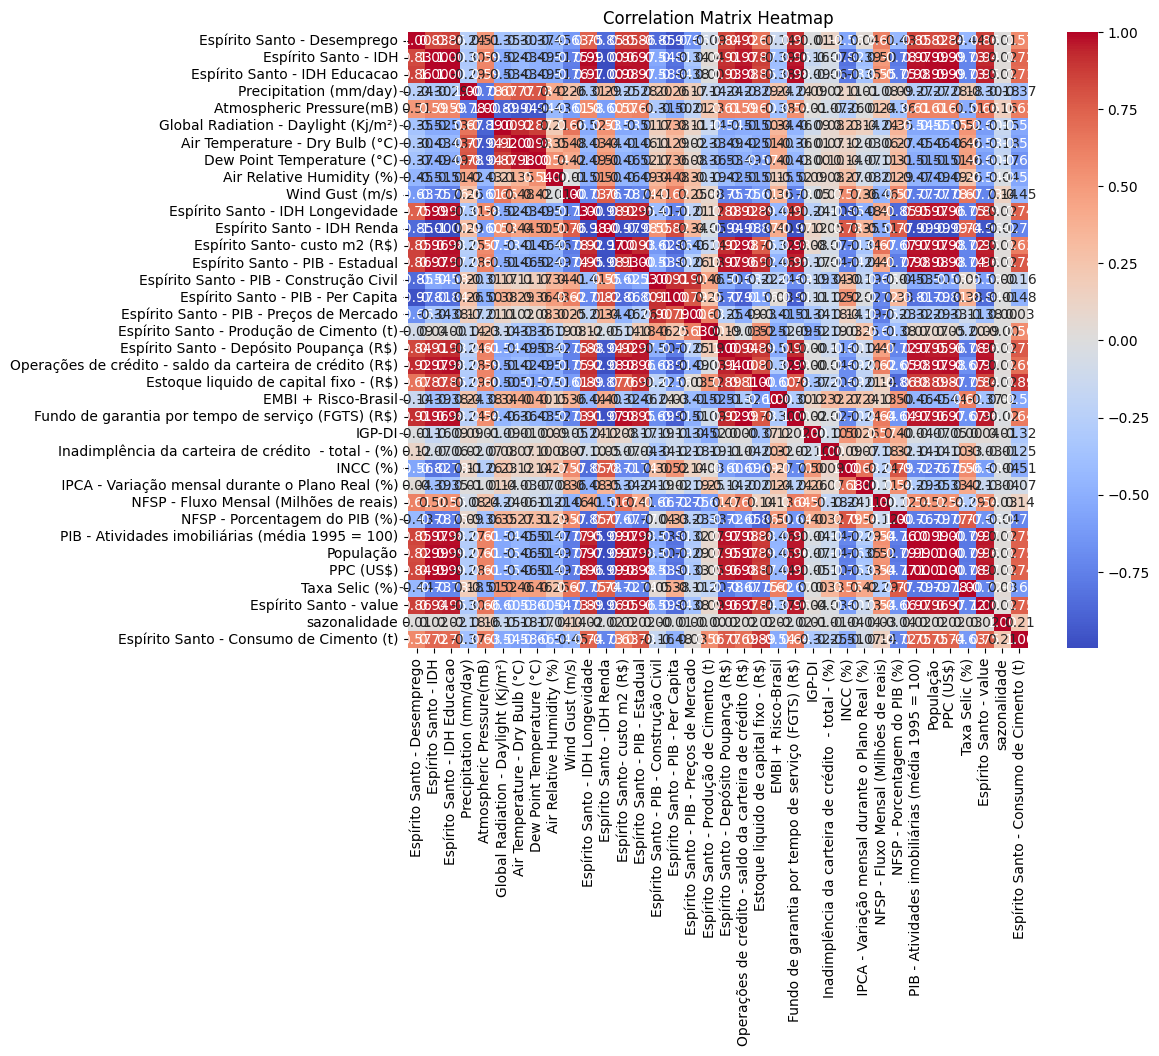

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Espírito Santo - Desemprego,8.811784e+04
1,Espírito Santo - IDH,3.467608e+09
2,Espírito Santo - IDH Educacao,1.215225e+06
3,Precipitation (mm/day),2.355370e+02
4,Atmospheric Pressure(mB),2.007826e+07
5,Global Radiation - Daylight (Kj/m²),5.077390e+03
6,Air Temperature - Dry Bulb (°C),3.219571e+05
7,Dew Point Temperature (°C),2.106155e+05
8,Air Relative Humidity (%),1.499493e+05
9,Wind Gust (m/s),2.424443e+03


In [39]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000000)
data

Num columns removed: 1


,Espírito Santo - Desemprego,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade
0,8.177444,0.698032,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,4.069229e+06,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445,90.455481
1,8.171622,0.698295,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,4.094341e+06,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512,83.073464
2,8.165799,0.698558,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,4.119454e+06,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941,93.552817
3,8.159977,0.698821,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,4.144566e+06,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321,86.493489
4,8.154154,0.699084,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,4.169679e+06,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453,87.214724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,10.095799,0.735648,1.866732,1017.848632,1204.779357,23.548745,18.983961,77.319458,1.584656,0.874389,0.731470,27874.903981,7.189511e+07,3.543595e+06,16.536559,5.974024e+07,71.670286,9.225920e+06,3.339533e+06,7.711687e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,0.393144,99.901936
200,10.085375,0.735610,2.051309,1016.620476,1261.780156,24.141735,19.479665,76.922913,1.653513,0.874191,0.731445,28102.393333,7.183202e+07,3.544798e+06,16.537046,5.973496e+07,71.113047,9.340846e+06,3.365687e+06,7.707969e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,0.397017,96.365147
201,10.074950,0.735571,2.251610,1015.332409,1286.383115,24.688328,20.019135,76.982935,1.682940,0.873992,0.731420,28334.526709,7.176894e+07,3.546002e+06,16.537532,5.972968e+07,70.574642,9.455773e+06,3.396904e+06,7.704251e+06,259.995111,1.094126e+07,1.188899,

In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,-1.887035,-0.590016,-0.042690,-0.017607,-0.340415,-0.314374,-0.003217,1.339171,-2.436580,1.955196,-1.562481,-1.995012,-0.918537,0.156307,-1.738146,-1.124954,-1.734303,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,-1.335752
1,-1.865195,-0.588690,-0.041279,-0.018611,-0.340833,-0.314936,-0.003931,1.334156,-2.391992,1.931236,-1.543542,-1.967644,-0.866915,0.195516,-1.642052,-1.131081,-1.718783,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,-1.289444
2,-1.843354,-0.587917,-0.040455,-0.019197,-0.341076,-0.315264,-0.004348,1.331231,-2.347403,1.907276,-1.525147,-1.940277,-0.815292,0.234725,-1.545958,-1.127206,-1.703262,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,-1.257407
3,-1.821514,-0.587834,-0.040367,-0.019260,-0.341102,-0.315300,-0.004392,1.330918,-2.302815,1.883316,-1.507179,-1.912909,-0.763669,0.273934,-1.449865,-1.118478,-1.687741,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,-1.226496
4,-1.799673,-0.543971,-0.073539,0.005635,-0.301998,-0.274048,0.020645,1.331651,-2.258226,1.859356,-1.489537,-1.885541,-0.712047,0.313143,-1.353771,-1.104535,-1.672220,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,-1.201131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.234665,0.016900,1.115267,-1.381086,-0.809190,-0.717277,0.163164,-1.367256,0.899219,-1.192105,1.838375,0.798713,-0.623044,-1.117152,-1.068708,-1.717699,1.452768,1.360064,0.117681,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.378950,1.402207,-1.370268,1.458381
200,1.231469,0.506624,0.635184,-1.036445,-0.480703,-0.462639,-0.040508,-1.055154,0.879653,-1.195162,1.882307,0.777906,-0.604910,-1.114794,-1.082415,-1.730162,1.523798,1.384545,0.092456,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.391539,1.410056,-1.390925,1.545150
201,1.228274,1.038069,0.131683,-0.887689,-0.177917,-0.185518,-0.009680,-0.921772,0.860087,-1.198218,1.927136,0.757099,-0.586776,-1.112436,-1.096122,-1.742205,1.594827,1.413764,0.067231,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.404128,1.417346,-1.527663,1.633660
202,1.225079,1.479766,-0.178468,-0.904307,0.112050,0.087290,0.071250,-1.006449,0.840521,-1.201275,1.974698,0.736292,-0.568642,-1.110078,-1.109830,-1.752853,1.665857,1.440408,0.042006,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.416717,1.423988,-1.609340,1.733092


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,-1.887035,-0.590016,-0.042690,-0.017607,-0.340415,-0.314374,-0.003217,1.339171,-2.436580,1.955196,-1.562481,-1.995012,-0.918537,0.156307,-1.738146,-1.124954,-1.734303,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,-1.335752
1,-1.865195,-0.588690,-0.041279,-0.018611,-0.340833,-0.314936,-0.003931,1.334156,-2.391992,1.931236,-1.543542,-1.967644,-0.866915,0.195516,-1.642052,-1.131081,-1.718783,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,-1.289444
2,-1.843354,-0.587917,-0.040455,-0.019197,-0.341076,-0.315264,-0.004348,1.331231,-2.347403,1.907276,-1.525147,-1.940277,-0.815292,0.234725,-1.545958,-1.127206,-1.703262,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,-1.257407
3,-1.821514,-0.587834,-0.040367,-0.019260,-0.341102,-0.315300,-0.004392,1.330918,-2.302815,1.883316,-1.507179,-1.912909,-0.763669,0.273934,-1.449865,-1.118478,-1.687741,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,-1.226496
4,-1.799673,-0.543971,-0.073539,0.005635,-0.301998,-0.274048,0.020645,1.331651,-2.258226,1.859356,-1.489537,-1.885541,-0.712047,0.313143,-1.353771,-1.104535,-1.672220,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,-1.201131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.277440,-0.832537,0.847826,-1.641384,-0.900618,-0.632405,0.739655,-1.501942,1.108759,-1.190136,1.467017,1.030438,-0.910092,-1.073379,-0.805078,-1.505524,0.926609,1.193119,0.391058,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.238976,1.279826,-1.152820,0.966284
188,1.273358,-0.566062,0.435721,-1.293576,-0.568666,-0.420436,0.355594,-1.150558,1.094244,-1.186250,1.485400,1.013223,-0.878071,-1.085435,-0.838614,-1.530072,0.932399,1.206925,0.371698,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.249345,1.291262,-1.253503,0.980677
189,1.269277,-0.626345,0.259864,-0.668274,-0.163653,-0.162376,-0.054470,-0.804024,1.079729,-1.182364,1.505643,0.996008,-0.846049,-1.097490,-0.872149,-1.552675,0.938189,1.227934,0.352338,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.259715,1.301919,-1.425444,1.002195
190,1.265195,0.021510,-0.000831,-0.129118,0.256930,0.122027,-0.406717,-0.752337,1.065213,-1.178478,1.528287,0.978793,-0.814027,-1.109546,-0.905685,-1.578967,0.943979,1.246115,0.332977,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.270085,1.311660,-1.237935,1.024866


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       56.490
1       53.578
2       60.481
3       64.833
4       64.063
        ...   
187    111.007
188    112.147
189    107.327
190     88.648
191     93.525
Name: Espírito Santo - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 32)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
156,1.239922,-0.149005,-0.213834,1.061905,0.980944,0.414308,-1.862029,0.077530,1.396695,-1.259132,0.926205,0.952852,-1.500213,-1.574016,-1.594405,0.036759,0.495431,1.222613,0.845472,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.903734,0.911463,0.407265,0.910789
157,1.242255,-0.125046,0.051750,0.959846,0.856604,0.253473,-2.055503,-0.236612,1.391053,-1.259211,0.945888,0.963483,-1.490734,-1.551871,-1.551917,-0.022748,0.507009,1.211968,0.833972,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.914718,0.922870,0.137084,0.912919
158,1.244589,-0.197421,0.442188,0.139819,0.354499,-0.016283,-1.274526,-0.875814,1.385411,-1.259290,0.964645,0.974114,-1.481254,-1.529725,-1.509429,-0.079829,0.518588,1.202030,0.822472,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.925702,0.935360,0.296087,0.914954
159,1.246922,-0.513957,0.806730,-0.586903,-0.163980,-0.409830,-0.931745,-1.264822,1.379770,-1.259369,0.983294,0.984745,-1.471774,-1.507580,-1.466940,-0.139797,0.530166,1.192181,0.810972,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.936687,0.948135,0.197300,0.917356
160,1.249255,-0.504184,1.172413,-0.971272,-0.632754,-0.798029,-0.807825,-1.362952,1.374128,-1.259447,1.001797,0.995376,-1.462295,-1.485434,-1.424452,-0.200973,0.541744,1.183708,0.799472,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.947671,0.961143,0.469403,0.919683
161,1.251589,-0.879622,1.361586,-1.130285,-0.868904,-0.979509,-0.705546,-1.223870,1.368486,-1.259526,1.020929,1.006008,-1.452815,-1.463289,-1.381964,-0.253266,0.553322,1.174004,0.787972,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.958655,0.973478,0.775434,0.924226
162,1.253922,-1.030719,1.246424,-1.038088,-0.866743,-0.988816,-0.797290,-0.883874,1.362845,-1.259605,1.041357,1.016639,-1.443335,-1.441143,-1.339476,-0.307884,0.564900,1.166949,0.776472,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.969639,0.985778,0.136553,0.928752
163,1.256255,-1.151394,0.962607,-0.911168,-0.752146,-0.856647,-0.721737,-0.587991,1.357203,-1.259684,1.061801,1.027270,-1.433856,-1.418998,-1.296987,-0.362529,0.576479,1.159632,0.764972,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.980624,0.999021,0.642038,0.933267
164,1.258589,-1.293205,0.590930,-0.740725,-0.484739,-0.576286,-0.573046,-0.340642,1.351562,-1.259763,1.080765,1.037901,-1.424376,-1.396852,-1.254499,-0.418212,0.588057,1.154709,0.753473,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,0.991608,1.012408,0.482412,0.939055
165,1.260922,-0.156711,0.239423,-0.240751,-0.126329,-0.321672,-0.838122,-0.042915,1.345920,-1.259842,1.099689,1.048532,-1.414897,-1.374707,-1.212011,-0.473280,0.599635,1.151483,0.741973,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.

In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 32)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[4108762743, 455859627, 221153204, 2497794309, 1177069562, 1655716260, 4179291130, 1837317001, 4050715220, 1366221816]


Step: 0 ___________________________________________
val_loss: 105.22882080078125
winner_seed: 4108762743


Step: 1 ___________________________________________
val_loss: 125.63153076171875


Step: 2 ___________________________________________
val_loss: 104.9854965209961
winner_seed: 221153204


Step: 3 ___________________________________________
val_loss: 150.17410278320312


Step: 4 ___________________________________________
val_loss: 127.10750579833984


Step: 5 ___________________________________________
val_loss: 113.24388885498047


Step: 6 ___________________________________________
val_loss: 138.2896728515625


Step: 7 ___________________________________________
val_loss: 118.5422134399414


Step: 8 ___________________________________________
val_loss: 130.8349609375


Step: 9 ___________________________________________
val_loss: 119.93685150146484


final_see

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2791720715

Epoch 1/10000
5/5 [==============================] - 2s 238ms/step - loss: 8767.8428 - val_loss: 466.7643
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 469.3699 - val_loss: 187.3671
Epoch 3/10000
5/5 [==============================] - 0s 9ms/step - loss: 145.3785 - val_loss: 191.3008
Epoch 4/10000
5/5 [==============================] - 0s 9ms/step - loss: 145.1026 - val_loss: 252.2147
Epoch 5/10000
5/5 [==============================] - 0s 9ms/step - loss: 144.4407 - val_loss: 201.1646
Epoch 6/10000
5/5 [==============================] - 0s 9ms/step - loss: 142.1420 - val_loss: 205.9287
Epoch 7/10000
5/5 [==============================] - 0s 9ms/step - loss: 139.3086 - val_loss: 125.9126
Epoch 8/10000
5/5 [==============================] - 0s 10ms/step - loss: 148.1969 - val_loss: 3233.8918
Epoch 9/10000
5/5 [==============================] - 0s 10ms/step - loss: 132.2254 - val_loss: 130.4369
Epoch 10/10000
5/5 [==============================] - 0s 10ms/step

5/5 [==============================] - 0s 9ms/step - loss: 64.5508 - val_loss: 350.8434
Epoch 81/10000
5/5 [==============================] - 0s 9ms/step - loss: 65.7574 - val_loss: 401.1292
Epoch 82/10000
5/5 [==============================] - 0s 10ms/step - loss: 67.6922 - val_loss: 308.2584
Epoch 83/10000
5/5 [==============================] - 0s 10ms/step - loss: 62.4351 - val_loss: 125.5962
Epoch 84/10000
5/5 [==============================] - 0s 10ms/step - loss: 89.1697 - val_loss: 172.8568
Epoch 85/10000
5/5 [==============================] - 0s 11ms/step - loss: 71.6601 - val_loss: 232.1120
Epoch 86/10000
5/5 [==============================] - 0s 11ms/step - loss: 69.6199 - val_loss: 289.7421
Epoch 87/10000
5/5 [==============================] - 0s 9ms/step - loss: 62.8562 - val_loss: 256.8767
Epoch 88/10000
5/5 [==============================] - 0s 9ms/step - loss: 62.5039 - val_loss: 306.3267
Epoch 89/10000
5/5 [==============================] - 0s 10ms/step - loss: 61.4957 

5/5 [==============================] - 0s 12ms/step - loss: 58.6995 - val_loss: 489.7270
Epoch 159/10000
5/5 [==============================] - 0s 10ms/step - loss: 64.8135 - val_loss: 382.7773
Epoch 160/10000
5/5 [==============================] - 0s 9ms/step - loss: 58.4073 - val_loss: 353.9777
Epoch 161/10000
5/5 [==============================] - 0s 9ms/step - loss: 56.8366 - val_loss: 277.6561
Epoch 162/10000
5/5 [==============================] - 0s 9ms/step - loss: 57.3924 - val_loss: 228.6318
Epoch 163/10000
5/5 [==============================] - 0s 9ms/step - loss: 59.3026 - val_loss: 313.1626
Epoch 164/10000
5/5 [==============================] - 0s 10ms/step - loss: 52.2654 - val_loss: 310.4396
Epoch 165/10000
5/5 [==============================] - 0s 10ms/step - loss: 55.1432 - val_loss: 385.9150
Epoch 166/10000
5/5 [==============================] - 0s 10ms/step - loss: 58.4634 - val_loss: 375.7006
Epoch 167/10000
5/5 [==============================] - 0s 10ms/step - loss:

5/5 [==============================] - 0s 9ms/step - loss: 58.7558 - val_loss: 284.8601
Epoch 237/10000
5/5 [==============================] - 0s 9ms/step - loss: 54.8241 - val_loss: 283.8130
Epoch 238/10000
5/5 [==============================] - 0s 9ms/step - loss: 56.4337 - val_loss: 185.7581
Epoch 239/10000
5/5 [==============================] - 0s 9ms/step - loss: 54.4999 - val_loss: 224.3464
Epoch 240/10000
5/5 [==============================] - 0s 10ms/step - loss: 52.6006 - val_loss: 255.1713
Epoch 241/10000
5/5 [==============================] - 0s 9ms/step - loss: 53.9920 - val_loss: 244.3165
Epoch 242/10000
5/5 [==============================] - 0s 10ms/step - loss: 56.6936 - val_loss: 299.0811
Epoch 243/10000
5/5 [==============================] - 0s 11ms/step - loss: 52.3627 - val_loss: 233.2194
Epoch 244/10000
5/5 [==============================] - 0s 9ms/step - loss: 52.8333 - val_loss: 142.8022
Epoch 245/10000
5/5 [==============================] - 0s 10ms/step - loss: 6

5/5 [==============================] - 0s 10ms/step - loss: 48.1015 - val_loss: 205.5767
Epoch 315/10000
5/5 [==============================] - 0s 11ms/step - loss: 50.4227 - val_loss: 213.1721
Epoch 316/10000
5/5 [==============================] - 0s 10ms/step - loss: 42.1924 - val_loss: 223.7005
Epoch 317/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.0037 - val_loss: 196.1274
Epoch 318/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.3567 - val_loss: 180.8012
Epoch 319/10000
5/5 [==============================] - 0s 11ms/step - loss: 44.5575 - val_loss: 149.1017
Epoch 320/10000
5/5 [==============================] - 0s 10ms/step - loss: 57.8389 - val_loss: 221.9775
Epoch 321/10000
5/5 [==============================] - 0s 10ms/step - loss: 44.2774 - val_loss: 245.8428
Epoch 322/10000
5/5 [==============================] - 0s 10ms/step - loss: 40.0137 - val_loss: 196.3601
Epoch 323/10000
5/5 [==============================] - 0s 10ms/step - l

5/5 [==============================] - 0s 10ms/step - loss: 47.0071 - val_loss: 194.5264
Epoch 393/10000
5/5 [==============================] - 0s 10ms/step - loss: 48.5094 - val_loss: 171.4371
Epoch 394/10000
5/5 [==============================] - 0s 12ms/step - loss: 44.2073 - val_loss: 176.3857
Epoch 395/10000
5/5 [==============================] - 0s 10ms/step - loss: 45.5462 - val_loss: 138.2018
Epoch 396/10000
5/5 [==============================] - 0s 10ms/step - loss: 51.1710 - val_loss: 147.5132
Epoch 397/10000
5/5 [==============================] - 0s 10ms/step - loss: 36.8870 - val_loss: 178.3791
Epoch 398/10000
5/5 [==============================] - 0s 9ms/step - loss: 38.0782 - val_loss: 163.2557
Epoch 399/10000
5/5 [==============================] - 0s 10ms/step - loss: 41.6929 - val_loss: 185.6841
Epoch 400/10000
5/5 [==============================] - 0s 10ms/step - loss: 41.8923 - val_loss: 151.3746
Epoch 401/10000
5/5 [==============================] - 0s 11ms/step - lo

5/5 [==============================] - 0s 10ms/step - loss: 52.6683 - val_loss: 226.8596
Epoch 471/10000
5/5 [==============================] - 0s 10ms/step - loss: 39.0347 - val_loss: 201.5067
Epoch 472/10000
5/5 [==============================] - 0s 9ms/step - loss: 36.8615 - val_loss: 296.0105
Epoch 473/10000
5/5 [==============================] - 0s 9ms/step - loss: 40.0600 - val_loss: 256.8143
Epoch 474/10000
5/5 [==============================] - 0s 9ms/step - loss: 36.5617 - val_loss: 233.3397
Epoch 475/10000
5/5 [==============================] - 0s 8ms/step - loss: 39.0444 - val_loss: 245.5405
Epoch 476/10000
5/5 [==============================] - 0s 9ms/step - loss: 36.6741 - val_loss: 190.9066
Epoch 477/10000
5/5 [==============================] - 0s 9ms/step - loss: 38.8403 - val_loss: 260.7273
Epoch 478/10000
5/5 [==============================] - 0s 10ms/step - loss: 37.4110 - val_loss: 211.5621
Epoch 479/10000
5/5 [==============================] - 0s 9ms/step - loss: 35

5/5 [==============================] - 0s 10ms/step - loss: 28.9399 - val_loss: 231.6398
Epoch 549/10000
5/5 [==============================] - 0s 8ms/step - loss: 32.8790 - val_loss: 228.4794
Epoch 550/10000
5/5 [==============================] - 0s 9ms/step - loss: 33.7753 - val_loss: 218.4886
Epoch 551/10000
5/5 [==============================] - 0s 9ms/step - loss: 30.1305 - val_loss: 237.2982
Epoch 552/10000
5/5 [==============================] - 0s 10ms/step - loss: 31.7668 - val_loss: 231.1116
Epoch 553/10000
5/5 [==============================] - 0s 10ms/step - loss: 27.3713 - val_loss: 264.7747
Epoch 554/10000
5/5 [==============================] - 0s 12ms/step - loss: 32.2437 - val_loss: 220.5220
Epoch 555/10000
5/5 [==============================] - 0s 12ms/step - loss: 31.8930 - val_loss: 263.3528
Epoch 556/10000
5/5 [==============================] - 0s 10ms/step - loss: 28.0088 - val_loss: 228.7893
Epoch 557/10000
5/5 [==============================] - 0s 9ms/step - loss:

5/5 [==============================] - 0s 10ms/step - loss: 24.8432 - val_loss: 244.4551
Epoch 627/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.9700 - val_loss: 233.8934
Epoch 628/10000
5/5 [==============================] - 0s 9ms/step - loss: 33.7662 - val_loss: 207.9025
Epoch 629/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.1701 - val_loss: 224.3813
Epoch 630/10000
5/5 [==============================] - 0s 10ms/step - loss: 27.6042 - val_loss: 219.5338
Epoch 631/10000
5/5 [==============================] - 0s 9ms/step - loss: 28.5263 - val_loss: 238.1718
Epoch 632/10000
5/5 [==============================] - 0s 10ms/step - loss: 27.6559 - val_loss: 217.9392
Epoch 633/10000
5/5 [==============================] - 0s 10ms/step - loss: 29.9512 - val_loss: 238.0837
Epoch 634/10000
5/5 [==============================] - 0s 9ms/step - loss: 28.5393 - val_loss: 207.8437
Epoch 635/10000
5/5 [==============================] - 0s 10ms/step - loss

Epoch 705/10000
5/5 [==============================] - 0s 8ms/step - loss: 31.0818 - val_loss: 164.8711
Epoch 706/10000
5/5 [==============================] - 0s 8ms/step - loss: 29.4249 - val_loss: 162.2604
Epoch 707/10000
5/5 [==============================] - 0s 8ms/step - loss: 27.5557 - val_loss: 181.5805
Epoch 708/10000
5/5 [==============================] - 0s 8ms/step - loss: 25.7013 - val_loss: 180.8446
Epoch 709/10000
5/5 [==============================] - 0s 8ms/step - loss: 24.0268 - val_loss: 203.5353
Epoch 710/10000
5/5 [==============================] - 0s 8ms/step - loss: 28.0587 - val_loss: 184.5387
Epoch 711/10000
5/5 [==============================] - 0s 8ms/step - loss: 27.0661 - val_loss: 183.3786
Epoch 712/10000
5/5 [==============================] - 0s 8ms/step - loss: 26.5175 - val_loss: 201.9941
Epoch 713/10000
5/5 [==============================] - 0s 9ms/step - loss: 25.5228 - val_loss: 194.0272
Epoch 714/10000
5/5 [==============================] - 0s 9ms/st

5/5 [==============================] - 0s 10ms/step - loss: 31.2708 - val_loss: 199.2210
Epoch 784/10000
5/5 [==============================] - 0s 9ms/step - loss: 29.5751 - val_loss: 171.6479
Epoch 785/10000
5/5 [==============================] - 0s 10ms/step - loss: 24.6649 - val_loss: 176.8805
Epoch 786/10000
5/5 [==============================] - 0s 9ms/step - loss: 24.1433 - val_loss: 190.5019
Epoch 787/10000
5/5 [==============================] - 0s 10ms/step - loss: 26.5365 - val_loss: 271.5112
Epoch 788/10000
5/5 [==============================] - 0s 10ms/step - loss: 36.5798 - val_loss: 186.3513
Epoch 789/10000
5/5 [==============================] - 0s 10ms/step - loss: 30.7406 - val_loss: 188.2138
Epoch 790/10000
5/5 [==============================] - 0s 10ms/step - loss: 29.1663 - val_loss: 190.9753
Epoch 791/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.2670 - val_loss: 208.8754
Epoch 792/10000
5/5 [==============================] - 0s 9ms/step - loss

5/5 [==============================] - 0s 8ms/step - loss: 27.3374 - val_loss: 156.5806
Epoch 862/10000
5/5 [==============================] - 0s 8ms/step - loss: 28.0958 - val_loss: 186.2774
Epoch 863/10000
5/5 [==============================] - 0s 8ms/step - loss: 25.3758 - val_loss: 178.6828
Epoch 864/10000
5/5 [==============================] - 0s 9ms/step - loss: 27.5737 - val_loss: 168.7439
Epoch 865/10000
5/5 [==============================] - 0s 9ms/step - loss: 28.4182 - val_loss: 145.4475
Epoch 866/10000
5/5 [==============================] - 0s 9ms/step - loss: 27.2077 - val_loss: 182.9433
Epoch 867/10000
5/5 [==============================] - 0s 9ms/step - loss: 26.3235 - val_loss: 173.8528
Epoch 868/10000
5/5 [==============================] - 0s 10ms/step - loss: 29.0120 - val_loss: 151.2802
Epoch 869/10000
5/5 [==============================] - 0s 10ms/step - loss: 26.2826 - val_loss: 191.3244
Epoch 870/10000
5/5 [==============================] - 0s 9ms/step - loss: 34.

5/5 [==============================] - 0s 11ms/step - loss: 25.8739 - val_loss: 155.3048
Epoch 940/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.6077 - val_loss: 164.7869
Epoch 941/10000
5/5 [==============================] - 0s 9ms/step - loss: 25.9955 - val_loss: 178.6195
Epoch 942/10000
5/5 [==============================] - 0s 11ms/step - loss: 23.4580 - val_loss: 190.9940
Epoch 943/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.0291 - val_loss: 183.7220
Epoch 944/10000
5/5 [==============================] - 0s 10ms/step - loss: 23.5506 - val_loss: 210.0878
Epoch 945/10000
5/5 [==============================] - 0s 11ms/step - loss: 23.8639 - val_loss: 151.0457
Epoch 946/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.1402 - val_loss: 173.1466
Epoch 947/10000
5/5 [==============================] - 0s 10ms/step - loss: 23.3993 - val_loss: 201.1633
Epoch 948/10000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 10ms/step - loss: 23.6910 - val_loss: 152.5242
Epoch 1018/10000
5/5 [==============================] - 0s 10ms/step - loss: 34.3277 - val_loss: 185.5043
Epoch 1019/10000
5/5 [==============================] - 0s 10ms/step - loss: 48.1700 - val_loss: 172.2357
Epoch 1020/10000
5/5 [==============================] - 0s 10ms/step - loss: 34.4535 - val_loss: 182.7150
Epoch 1021/10000
5/5 [==============================] - 0s 12ms/step - loss: 33.8817 - val_loss: 155.0754
Epoch 1022/10000
5/5 [==============================] - 0s 10ms/step - loss: 37.4096 - val_loss: 195.3543
Epoch 1023/10000
5/5 [==============================] - 0s 10ms/step - loss: 40.8858 - val_loss: 183.4954
Epoch 1024/10000
5/5 [==============================] - 0s 10ms/step - loss: 34.9752 - val_loss: 153.0295
Epoch 1025/10000
5/5 [==============================] - 0s 11ms/step - loss: 31.7274 - val_loss: 139.9860
Epoch 1026/10000
5/5 [==============================] - 0s 10ms

Epoch 1095/10000
5/5 [==============================] - 0s 10ms/step - loss: 20.5189 - val_loss: 193.1655
Epoch 1096/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.8861 - val_loss: 188.4129
Epoch 1097/10000
5/5 [==============================] - 0s 10ms/step - loss: 27.7845 - val_loss: 144.0005
Epoch 1098/10000
5/5 [==============================] - 0s 9ms/step - loss: 26.9962 - val_loss: 239.6375
Epoch 1099/10000
5/5 [==============================] - 0s 10ms/step - loss: 38.2372 - val_loss: 167.8532
Epoch 1100/10000
5/5 [==============================] - 0s 10ms/step - loss: 37.7089 - val_loss: 152.2149
Epoch 1101/10000
5/5 [==============================] - 0s 11ms/step - loss: 23.7155 - val_loss: 145.3392
Epoch 1102/10000
5/5 [==============================] - 0s 10ms/step - loss: 24.0991 - val_loss: 144.8665
Epoch 1103/10000
5/5 [==============================] - 0s 9ms/step - loss: 24.2391 - val_loss: 142.0938
Epoch 1104/10000
5/5 [==========================

5/5 [==============================] - 0s 9ms/step - loss: 40.6648 - val_loss: 154.0626
Epoch 1173/10000
5/5 [==============================] - 0s 9ms/step - loss: 35.6012 - val_loss: 151.5774
Epoch 1174/10000
5/5 [==============================] - 0s 9ms/step - loss: 34.1278 - val_loss: 141.7805
Epoch 1175/10000
5/5 [==============================] - 0s 8ms/step - loss: 27.3038 - val_loss: 161.2623
Epoch 1176/10000
5/5 [==============================] - 0s 9ms/step - loss: 25.1192 - val_loss: 149.5741
Epoch 1177/10000
5/5 [==============================] - 0s 9ms/step - loss: 22.0293 - val_loss: 161.7520
Epoch 1178/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.2913 - val_loss: 154.1767
Epoch 1179/10000
5/5 [==============================] - 0s 9ms/step - loss: 23.7619 - val_loss: 133.4451
Epoch 1180/10000
5/5 [==============================] - 0s 9ms/step - loss: 25.1058 - val_loss: 156.8971
Epoch 1181/10000
5/5 [==============================] - 0s 9ms/step - lo

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,90.40519,89.99704,89.021446,87.813538,85.779076,85.235321,92.100899,95.940704,96.82,96.606972,95.410942,93.95369
Target,107.05,87.266,110.781,90.704,89.617,88.47,102.447,108.121,97.858,82.086,88.846,81.776
Error,16.644814,2.731041,21.759552,2.890465,3.837921,3.23468,10.3461,12.180298,1.038002,14.520973,6.564941,12.177689


In [54]:
display(mae)
display(mape)

8.993873

0.09320117

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[1099.0848]] - Target[1135.0220000000002]| =  Error: [[35.937134]]; MAPE:[[0.03166206]]


[array([[35.937134]], dtype=float32)]

35.937134

0.03166206